In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [3]:
df = pd.read_csv('/Users/sadhgunasri/Desktop/AI_PROJECT/imdb_master.csv')  # Use the new CSV file
print(df.shape)

df = df.head(500)
print(df.shape)

print(df.head())

(100000, 4)
(500, 4)
   type                                             review label         file
0  test  Once again Mr. Costner has dragged out a movie...   neg      0_2.txt
1  test  This is an example of why the majority of acti...   neg  10000_4.txt
2  test  First of all I hate those moronic rappers, who...   neg  10001_1.txt
3  test  Not even the Beatles could write songs everyon...   neg  10002_3.txt
4  test  Brass pictures (movies is not a fitting word f...   neg  10003_3.txt


In [4]:
df = pd.read_csv('/Users/sadhgunasri/Desktop/AI_PROJECT/imdb_master.csv')  # Use the new CSV file
print(df.columns)


Index(['type', 'review', 'label', 'file'], dtype='object')


In [5]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/Users/sadhgunasri/Desktop/AI_PROJECT/imdb_master.csv')

df = df[df['label'].isin(['pos', 'neg'])]

label_map = {"neg": 0, "pos": 1}
df["label"] = df["label"].map(label_map)

df = df[['review', 'label']]

#Remove missing or blank reviews
df.dropna(inplace=True)
df = df[df['review'].str.strip() != ""]

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(df.head())
print(f"Dataset shape: {df.shape}")


                                              review  label
0  Imagine The Big Chill with a cast of twenty-so...      0
1  I'd have to say that I've seen worse Sci Fi Ch...      0
2  Director Fabio Barreto got a strange Academy N...      0
3  Pretty bad PRC cheapie which I rarely bother t...      0
4  This is a very intriguing short movie by David...      1
Dataset shape: (50000, 2)


In [6]:
from transformers import RobertaTokenizer
from datasets import Dataset
import torch

#Load RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

dataset = Dataset.from_pandas(df)

def tokenize_function(example):
    return tokenizer(example["review"], truncation=True, padding="max_length", max_length=128)

#Apply tokenizer to dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

train_test_split = tokenized_dataset.train_test_split(test_size=0.2)

print(train_test_split["train"][0])


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

{'labels': tensor(0), 'input_ids': tensor([    0,  2847,  1717,  5471,    42,   693,    34,    10, 32461,    14,
        29384,    82,    88,    24,    77,    51,  1717,  5471,   109,    24,
            8,    89,    18,    42, 22633,    54,   101,  3905,    69,   198,
          734, 22466,  8569, 17220,   463,  1717, 36646,    16,  1717,  5471,
           11,   657,    19,    69,     8,    79, 17672,   657,   123,   124,
          142,     9,    69,   631,   219,     4,  2647,    69,   631,   219,
         2012,  1686,     7,    69,   734, 41685,     9,   734,   405,    95,
          161,  3993,   162,    81,     8,    81,     8,    79,  5741,     7,
         3993,    24,  2131,  3678,    53,    14,   630,    75,   173,   142,
           24,  1717,  5471, 41311,  1072,  2310,  4884, 17516,   116, 12846,
          116,   407,    42,   693,  3885,     7,     5,  1275,  1109,  1418,
          147,    79,  5916,    62,  6349,    53,   129,     5,   269, 18388,
        24832,  1980,  1303, 

In [7]:
from transformers import RobertaForSequenceClassification, TrainingArguments, Trainer

model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Corrected: Changed from evaluation_strategy to eval_strategy
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test_split["train"], # Assuming train_test_split is defined elsewhere
    eval_dataset=train_test_split["test"],   # Assuming train_test_split is defined elsewhere
)

#start training
trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/sadhgunasri/myenv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,0.338800,0.334463
2,0.278400,0.411703
3,0.137500,0.467559


/Users/sadhgunasri/myenv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/sadhgunasri/myenv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=15000, training_loss=0.2635307947794596, metrics={'train_runtime': 17226.5695, 'train_samples_per_second': 6.966, 'train_steps_per_second': 0.871, 'total_flos': 7893331660800000.0, 'train_loss': 0.2635307947794596, 'epoch': 3.0})

In [10]:
from transformers import RobertaTokenizerFast

# save with model
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
tokenizer.save_pretrained("sentiment_model_roberta")  # save with model


('sentiment_model_roberta/tokenizer_config.json',
 'sentiment_model_roberta/special_tokens_map.json',
 'sentiment_model_roberta/vocab.json',
 'sentiment_model_roberta/merges.txt',
 'sentiment_model_roberta/added_tokens.json',
 'sentiment_model_roberta/tokenizer.json')

In [1]:
from transformers import pipeline

model = pipeline("sentiment-analysis", model="sentiment_model_roberta")

label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Positive"
}

texts = [
    "I love this product!",
    "I watched a english movie that was horrible"
]

for text in texts:
    result = model(text)[0]  # Get the first (and only) prediction
    label = label_map.get(result['label'], result['label'])  # Map label if possible
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {label} (Confidence: {result['score']:.2f})\n")


Device set to use mps:0


Text: I love this product!
Predicted Sentiment: Positive (Confidence: 0.99)

Text: I watched a english movie that was horrible
Predicted Sentiment: Negative (Confidence: 0.99)



Device set to use mps:0


Accuracy: 0.6667

Classification Report:
              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67         1
    Positive       1.00      0.50      0.67         2

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3



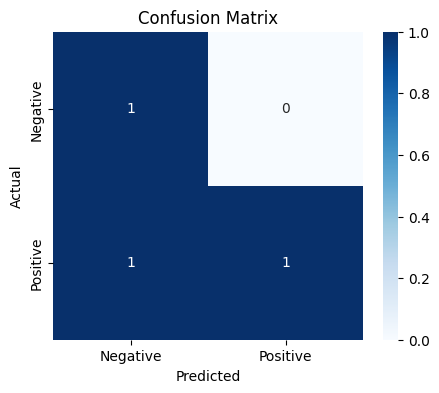

In [2]:
#training and testing accuracy results
from transformers import pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model = pipeline("sentiment-analysis", model="sentiment_model_roberta")

test_texts = [
    "I love this product!",            # Expected Positive → 1
    "This is the worst experience.",   # Expected Negative → 0
    "It was okay, not too bad."        # Expected Positive → 1 (if only binary)
]

true_labels = [1, 0, 1]  # Replace with actual labels for your samples

preds = model(test_texts)

pred_labels = [1 if p['label'] == 'LABEL_1' else 0 for p in preds]

accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=["Negative", "Positive"]))

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
